<a href="https://colab.research.google.com/github/casoliveros95/2022-20-TalleresDL/blob/main/Taller%203/Taller_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Taller 3**

La comunidad científica es de la comunidad más activa que existe a la hora de realizar publicaciones en grandes revistas. Los avances tecnológicos, las facilidades a la hora de encontrar información y la gran cantidad de médicos dedicados a realizar estudios y publicarlos ha aumentado a tal punto que realizar una categorización de estos textos sería ideal para poder filtrar la información y acceder a ella de una manera más rápida y precisa.

Para eso, le han disponibilizado los *Abstracts* de diferentes artículos de los cuales los expoertos los han clasificado en diferentes categorias, y la idea es poder automatizar este proceso para que futuros artículos puedan ser clasificados automáticamente sin necesidad de disponer del tiempo de los expertos.

Para resolver el modelo, es importante que construyan la mejor Red Neuronal Recurrente que puedan encontrar. El procesamiento, la tokenización, la limpieza de los textos, la definición de los Embedding y la arquitectura de la Red Neuronal, así como la utilización de Redes Preentrenadas están a su criterio. Lo importante es documentar todos los pasos anteriormente descritos.

Datos: https://raw.githubusercontent.com/Camilojaravila/202210_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/main/Taller%202/train.dat

# Integrantes
- Carlos Santiago Oliveros
- Juan Manuel Sáenz

# Análisis del problema
Se requiere realizar un modelo de red recurrente de clasificación de textos (abstracts de papers) de multiples categorías (etiquetas excluyentes). 

Es importante destacar que a pesar que las publicaciones están dentro de un contexto médico, la clasificación se utilizará para identificar los temas para facilitar su lectura, no como ayuda para el diagnóstico de condiciones clínicas. Esto se deberá tener en cuenta para la optimización de las redes utilizads.

Dado que no se cuenta con mayor información a los datos del enlace, es necesario realizar una exploración de los datos para identificar características importantes del problema.

# 0. Importación de librerías

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions
import nltk
nltk.download('all')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Analisis profundo de datos
from pandas_profiling import ProfileReport

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [5]:
#Entrenamiento del modelo
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
import keras_tuner as kt

In [7]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

#Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras import Sequential
from keras.layers import Flatten, Dense, Embedding, GlobalAveragePooling1D
from keras.layers import TextVectorization
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import six
import os
import os.path as osp
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import plotly.graph_objects as go
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
import pickle

from numpy.random import seed
seed(33)

# 1. Carga de la información

In [9]:
!wget https://raw.githubusercontent.com/Camilojaravila/202210_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/main/Taller%202/train.dat

--2022-11-15 16:44:35--  https://raw.githubusercontent.com/Camilojaravila/202210_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/main/Taller%202/train.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17811683 (17M) [text/plain]
Saving to: ‘train.dat.1’

train.dat.1         100%[===================>]  16.99M  85.7MB/s    in 0.2s    

2022-11-15 16:44:35 (85.7 MB/s) - ‘train.dat.1’ saved [17811683/17811683]



In [10]:
Data = pd.read_csv( 'train.dat' , sep="\t" , names=['Clase','Texto'] , header=None )
Data

Clase                                              Texto
0          4  Catheterization laboratory events and hospital...
1          5  Renal abscess in children. Three cases of rena...
2          2  Hyperplastic polyps seen at sigmoidoscopy are ...
3          5  Subclavian artery to innominate vein fistula a...
4          4  Effect of local inhibition of gamma-aminobutyr...
...      ...                                                ...
14433      4  Quadricuspid aortic valve and aortic regurgita...
14434      1  Mammographic measurements before and after aug...
14435      1  Use of leukocyte-depleted platelet concentrate...
14436      2  Complications of Tenckhoff catheters post remo...
14437      3  Fatal or severely disabling cerebral infarctio...

[14438 rows x 2 columns]

Se verifica el número de categorías del problema.

In [11]:
ProfileReport(Data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Como se puede evidenciar, existen 5 clases en total que se encuentran desbalanceadas.

## Separación en datos de entranamiento y de evaluación.

In [12]:
train, test = train_test_split(Data, test_size=0.2, random_state=33)
test.head()

Clase                                              Texto
3646      2  Limitations in the evaluation of therapy in in...
4218      4  Long term follow-up of descending thoracic aor...
7625      1  Nuclear grading of breast carcinoma by image a...
2839      1  Direct interaction of a ligand for the erbB2 o...
8148      5  Mechanical measures in the prophylaxis of post...

Separación en entrenamiento y validación.

In [13]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=33)
train_df.head()

Clase                                              Texto
7852      5  Effect of antiarrhythmic therapy on mortality ...
4404      3  Cerebral malaria in children Cerebral malaria ...
864       5  Gaucher's disease complicated by bleeding esop...
4448      3  Risk factors for metastases in patients with r...
6203      3  The association of hydrocephalus with intramed...

In [14]:
X_test = test.drop(['Clase'], axis=1)
Y_test = test['Clase']


X_val = val_df.drop(['Clase'], axis=1)
Y_val = val_df['Clase']


X_train = train_df.drop(['Clase'], axis=1)
Y_train = train_df['Clase']

Visualización de algunas métricas y características de la BD de entrenamiento.

In [15]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 

def mostrar_grafico(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

---------- Words for class: 1 ----------


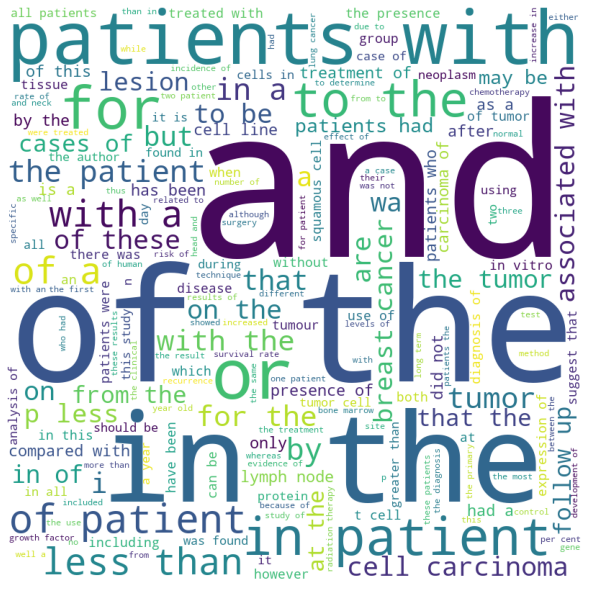

---------- Words for class: 2 ----------


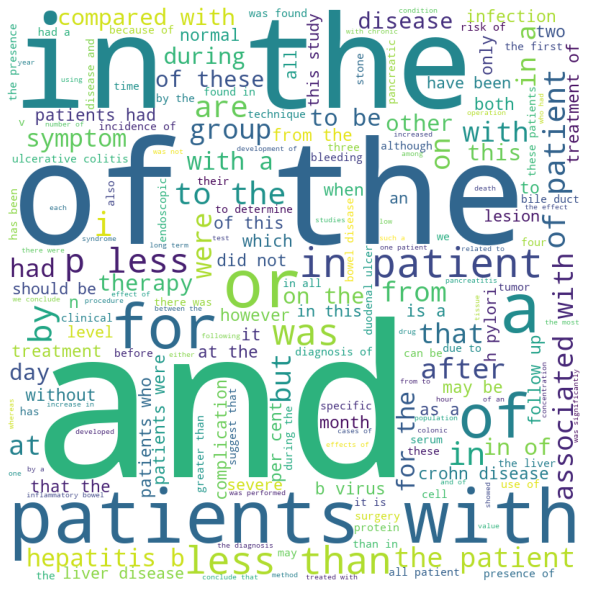

---------- Words for class: 3 ----------


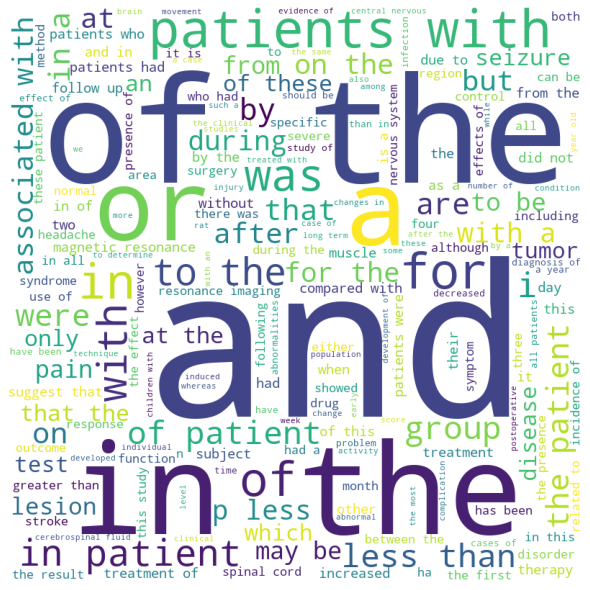

---------- Words for class: 4 ----------


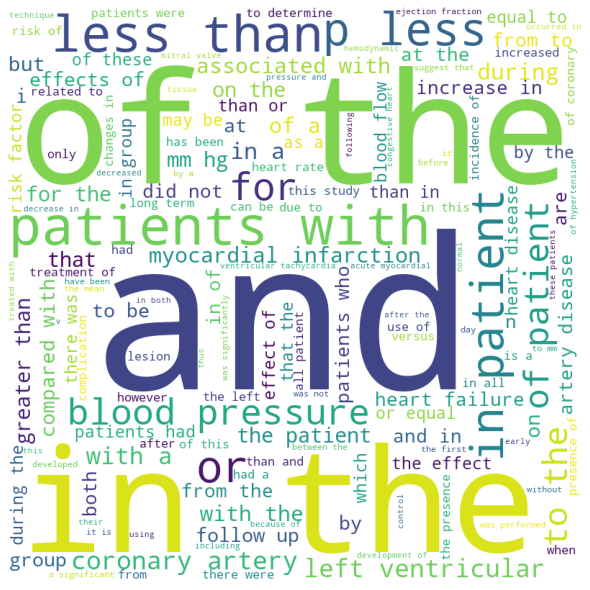

---------- Words for class: 5 ----------


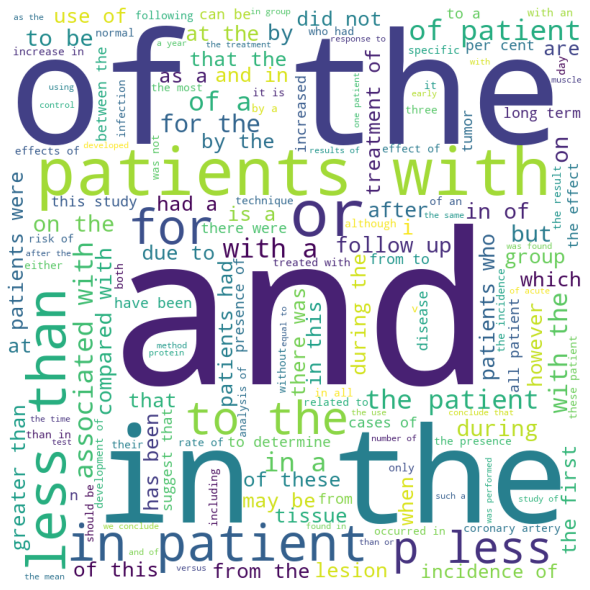

In [16]:
for i in range(5):
    print(f'---------- Words for class: {i+1} ----------')
    mostrar_grafico(Data.loc[Data['Clase']==(i+1),'Texto'])

Se repite el ejercicio ahora eliminando conectores y artículos.

---------- Words for class: 1 ----------


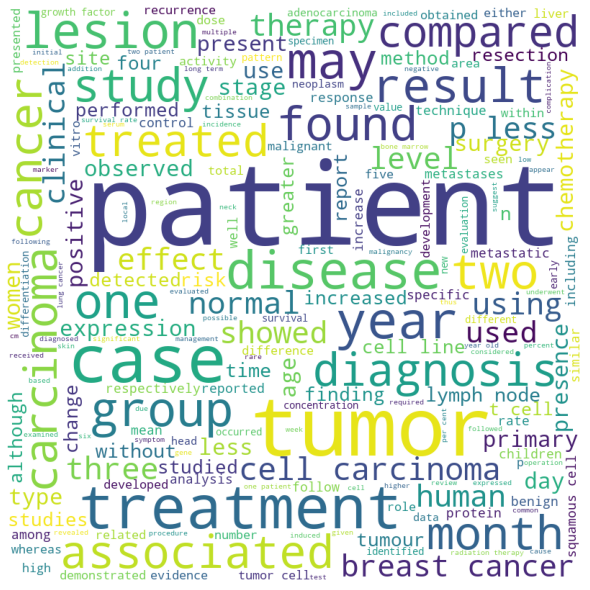

---------- Words for class: 2 ----------


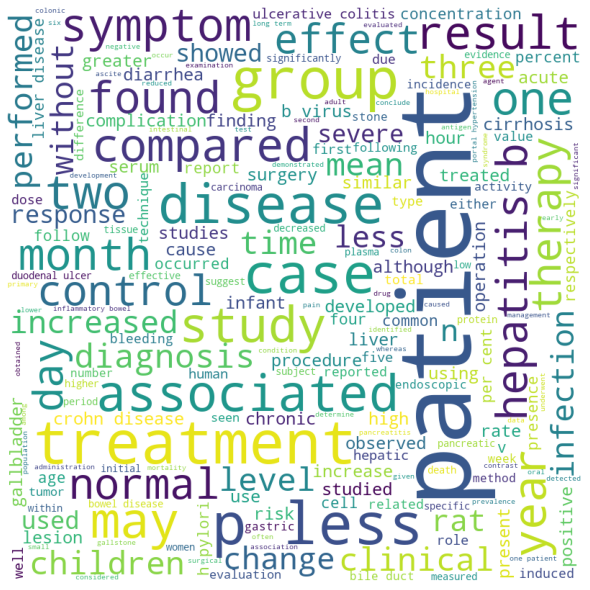

---------- Words for class: 3 ----------


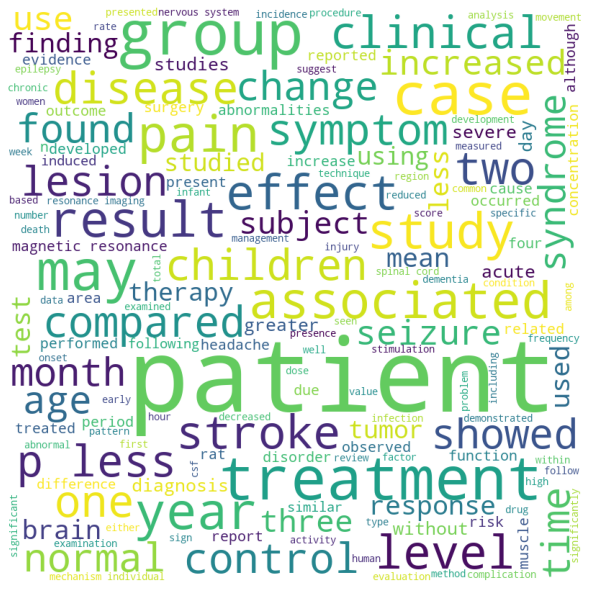

---------- Words for class: 4 ----------


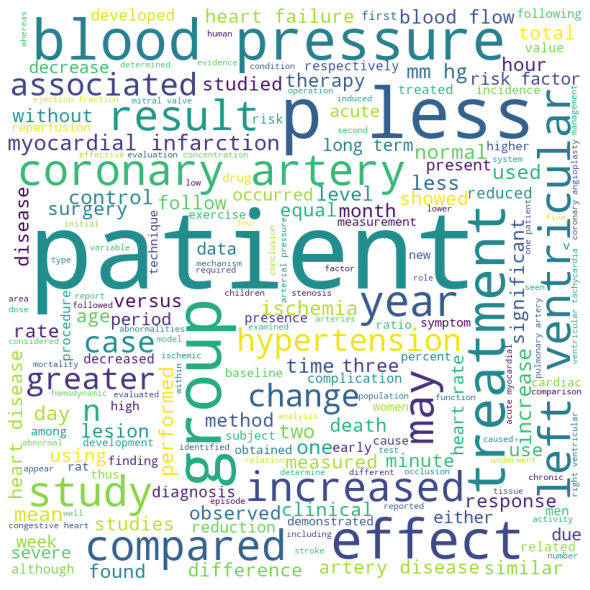

---------- Words for class: 5 ----------


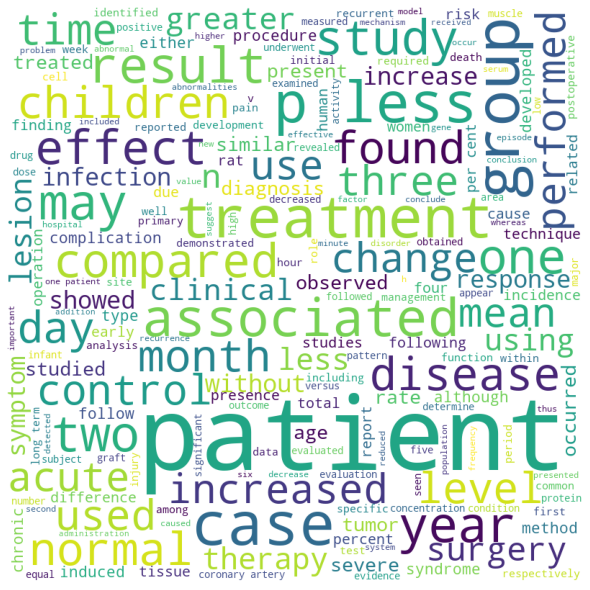

In [17]:
for i in range(5):
    print(f'---------- Words for class: {i+1} ----------')
    mostrar_grafico(Data.loc[Data['Clase']==(i+1),'Texto'],stopwords=STOPWORDS)

De las gráficas anteriores se puede ver que:
- Se comparte como palabra principal "Paciente" para las 5 categorías, en consistencia con el contexto médico de todas.
- La Clase 1: se encuentra relacionada con cancer.
- La Clase 2: se encuentra relacionada con hepatitis.
- La Clase 3: se encuentra relacioanda con infartos.
- La Clase 4: se encuentra relacionada con enferemedades cardiovasculares.
- La Clase 5: se encuentra relacionada con infecciones.


# 2. Preparación de la información

Dado que se trata de un texto, es necesario realizar una preparación detallada de como interpretar la información. En esta sección se desarrollan funciones que permiten:
- Uniformizar los formatos.
- Reducir el tamaño del diccionario.
- Eliminar ruido.
- Finalmente, convertir los textos a una codificación vectorial de longitud definida, que es lo que requiere la red RRN para su definición y entrenamiento.

In [18]:
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import contractions
import inflect
import re, string, unicodedata
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Se construyen funciones para realizar distintas normalizaciones y simplificaciones a la red.
- Remover caracteres simbólicos: dado el contexto, se considera más importante prestar atención al contenido escrito que a la existencia de caracteres de ecuaciones o similares.

- Convertir a minúsculas: simplificación para no considerar más de una vez palabras entre mayúsculas y minúsculas.

- Remover signos de puntuación: dado el contexto, se considera más importante prestar atención al contenido escrito que a la existencia de caracteres de ecuaciones o similares.

- Convetir números a texto: de ser posible se transforman los números a textos.

- Eliminar conectores, artículos,..: se borran palabras repetitivas que realmente no aportan diferencias en el contexto.

- "Stemming" o simplificación de palabras derivadas: busca agrupar palabras derivadas de otras (abrir, abierto, abriendo)

- Lematización de plurales y singulares: reduce la dimensionalidad de los textos convirtiendo plurales en singulares de modo que no se toman más de una vez. 

In [19]:
# Función para remover caracteres simbólicos.
# Dado el contexto, se considera más importante prestar atención al contenido escrito
# Que a posibles símbolos de ecuaciones o similares.
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# Simplifica todas las palabras a minúsculas. De modo que no consideren como pallabras
#distintas
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Eliminación de puntuación del contenido. Se consider nuevamente que dado el contexto
# es más importante el contenido que tal vez el número de tildes, puntos, ...
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Los números se convierten a textos de ser posible.
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

# Se eliminan palabras como conectores y artículos que no afectan significativamente el contenido.
# a la vez que son muy repetitivas.
def remove_stopwords(words, stopwords=stopwords.words('english')):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# Ahora, se reducen las palabras por "Stemming", que busca agrupar palabras
# derivadas de otras (abrir, abierto, abriendo). Que en términos de contexto aportan 
#lo mismo, y al reducirse reducen el tamaño del diccionario.
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

# Lematización es un proces similar, donde se reducen los plurales y los singulares.
# De nuevo que en términos de contexto aportan lo mismo.
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

# Una función auxiliar para realizar ambas lematización y stemming.
def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

# función auxiliar para realizar todas las anteriores.
def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words


Se ejecutan la tokenización, estandarización y normalización de los texto, a la vez que luego realiza una transformación bag-of-words (arbitrariamente como prueba).

In [20]:
X_train2= train_df['Texto'].apply(contractions.fix) #Aplica la corrección de las contracciones
X_train2 = X_train2.apply(word_tokenize)
X_train2 = X_train2.apply(preproccesing) #Aplica la eliminación del ruido
X_train2 = X_train2.apply(stem_and_lemmatize) 
X_train2.head()

7852    [effect, antiarrhythm, therapy, mort, surv, my...
4404    [cerebr, malar, childr, cerebr, malar, rapid, ...
864     [gauch, diseas, comply, blee, esoph, var, colo...
4448    [risk, fact, metastas, paty, retinoblastom, st...
6203    [assocy, hydrocephal, intramedul, spin, cord, ...
Name: Texto, dtype: object

In [21]:
X_val2= val_df['Texto'].apply(contractions.fix) #Aplica la corrección de las contracciones
X_val2 = X_val2.apply(word_tokenize)
X_val2 = X_val2.apply(preproccesing) #Aplica la eliminación del ruido
X_val2 = X_val2.apply(stem_and_lemmatize) 
X_val2.head()

13828    [predict, fre, phenytoin, level, bas, tot, phe...
11147    [induc, transform, grow, fact, bet, on, resist...
9256     [gen, assay, phosphoprotein, cerebrospin, flui...
7027     [var, reblee, portosystem, shunt, strategies, ...
7463     [behavy, mod, colon, funct, constip, learn, ch...
Name: Texto, dtype: object

In [22]:
train_df['trans'] = X_train2.apply(lambda x: ' '.join(map(str, x)))
val_df['trans'] = X_val2.apply(lambda x: ' '.join(map(str, x)))

display( train_df.head() )
display( val_df.head() )

Clase                                              Texto  \
7852      5  Effect of antiarrhythmic therapy on mortality ...   
4404      3  Cerebral malaria in children Cerebral malaria ...   
864       5  Gaucher's disease complicated by bleeding esop...   
4448      3  Risk factors for metastases in patients with r...   
6203      3  The association of hydrocephalus with intramed...   

                                                  trans  
7852  effect antiarrhythm therapy mort surv myocard ...  
4404  cerebr malar childr cerebr malar rapid progres...  
864   gauch diseas comply blee esoph var colon infil...  
4448  risk fact metastas paty retinoblastom study ba...  
6203  assocy hydrocephal intramedul spin cord tum se...

Clase                                              Texto  \
13828      3  Prediction of free phenytoin levels based on [...   
11147      5  Induction of transforming growth factor beta 1...   
9256       1  General assay for phosphoproteins in cerebrosp...   
7027       5  Variceal rebleeding after portosystemic shunti...   
7463       5  Behavioral modification of colonic function. C...   

                                                   trans  
13828  predict fre phenytoin level bas tot phenytoin ...  
11147  induc transform grow fact bet on resist e1a on...  
9256   gen assay phosphoprotein cerebrospin fluid can...  
7027   var reblee portosystem shunt strategies solv v...  
7463   behavy mod colon funct constip learn challeng ...

Se realizará un primer modelo de LSTM.

In [23]:
# The maximum number of words to be used.
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(  train_df['trans'].values  )

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 29734 unique tokens.


La BD de entrenamiento original tiene 9249 instancias.

In [24]:
display( train_df.shape )

(9240, 3)

La BD  de validación tiene 2310.

In [25]:
display( val_df.shape )

(2310, 3)

Se arreglan ahora el vector de entrenamiento y el vector de validación.

In [26]:
X_t1 = tokenizer.texts_to_sequences( train_df['trans'].values)
X_t1 = pad_sequences(X_t1, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_t1.shape) 

Shape of data tensor: (9240, 250)


In [27]:
X_v1 = tokenizer.texts_to_sequences( val_df['trans'].values)
X_v1 = pad_sequences(X_v1, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_v1.shape) 

Shape of data tensor: (2310, 250)


In [28]:
X_v1

array([[   0,    0,    0, ...,    1,  110, 6810],
       [   0,    0,    0, ...,   38, 5702,   57],
       [   0,    0,    0, ...,  342, 1022,  305],
       ...,
       [   0,    0,    0, ...,  321,  294, 7222],
       [   0,    0,    0, ...,   25, 8557, 4195],
       [   0,    0,    0, ..., 5241,  482, 4260]], dtype=int32)

Ahora, se arreglan los vectores de las categorías.

In [29]:
Y_t1 = pd.get_dummies(train_df['Clase']).values
print('Shape of label tensor:', Y_t1.shape)

Shape of label tensor: (9240, 5)


In [30]:
Y_t1

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [31]:
Y_v1 = pd.get_dummies(val_df['Clase']).values
print('Shape of label tensor:', Y_v1.shape)

Shape of label tensor: (2310, 5)


In [32]:
Y_v1

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

Comparando con la visualización de las BD realizada anteriormente, se organizaron de forma adecuada las categorías entre ambos grupos.

# 3. Modelo de LSTM
Se decide por realizar un modelo de LSTM recurrente oringinal como ejercicio autónomo de desarrollo.

## 3.1 Capa de embedding
El modelo LSTM incluirá una capa de embedding que de forma similar al "encoder" reduce la dimensionalidad del diccionario completo. Esto corresponde a un hiperparámetro que será tenido en cuenta más adelante.

El embedding funciona de la siguiente forma:

In [52]:
embedding_layer = tf.keras.layers.Embedding(MAX_NB_WORDS, 20)

Donde, los arrays de entrada son reducidos a uno de dimensionalidad menor. 20 en este caso.

In [53]:
result = embedding_layer(tf.constant( Y_v1[0] ))
result.numpy()

array([[-0.00480663, -0.00627986, -0.0431594 ,  0.04768795,  0.02221123,
         0.03870699, -0.02756645, -0.02795143,  0.03680669,  0.01309241,
        -0.03217842, -0.00777416, -0.02648957, -0.01203017, -0.03416987,
        -0.0464404 , -0.02892333, -0.01450934, -0.01903269,  0.00796754],
       [-0.00480663, -0.00627986, -0.0431594 ,  0.04768795,  0.02221123,
         0.03870699, -0.02756645, -0.02795143,  0.03680669,  0.01309241,
        -0.03217842, -0.00777416, -0.02648957, -0.01203017, -0.03416987,
        -0.0464404 , -0.02892333, -0.01450934, -0.01903269,  0.00796754],
       [ 0.00346468, -0.02507172, -0.02096034, -0.01980662,  0.0088581 ,
         0.04606918, -0.04169929,  0.03130228, -0.04006293,  0.00310179,
        -0.00364317, -0.00654274,  0.02565743, -0.02522295, -0.03517417,
        -0.02784248, -0.01013501, -0.04308571,  0.0319952 , -0.01956939],
       [-0.00480663, -0.00627986, -0.0431594 ,  0.04768795,  0.02221123,
         0.03870699, -0.02756645, -0.02795143,  

Los modelos construidos en este ejercicio incluyen una capa de esta al inicio de las secuencias.

##3.2 Modelo de linea base
Se construye un primer modelo para evidenciar el funcionamiento y ejecución en un caso sencillo.

Ahora, una vez organizado el texto del problema se procede a construir la LSTM.

In [44]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_t1.shape[1] ) )
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


In [46]:
epochs = 5
batch_size = 64

history = model.fit(X_t1, Y_t1, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=( X_v1, Y_v1 ),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
145/145 [==============================] - 138s 920ms/step - loss: 1.3971 - accuracy: 0.4148 - val_loss: 1.2394 - val_accuracy: 0.4948
Epoch 2/5
145/145 [==============================] - 131s 903ms/step - loss: 1.0687 - accuracy: 0.5686 - val_loss: 1.1150 - val_accuracy: 0.5433
Epoch 3/5
145/145 [==============================] - 131s 904ms/step - loss: 0.8302 - accuracy: 0.6732 - val_loss: 1.1346 - val_accuracy: 0.5502
Epoch 4/5
145/145 [==============================] - 129s 887ms/step - loss: 0.6875 - accuracy: 0.7264 - val_loss: 1.1955 - val_accuracy: 0.5364
Epoch 5/5
145/145 [==============================] - 127s 879ms/step - loss: 0.5936 - accuracy: 0.7587 - val_loss: 1.3071 - val_accuracy: 0.5117


Se revisan las métricas del rendimiento del modelo.

In [55]:
pred = model.predict(X_v1)

73/73 [==============================] - 8s 102ms/step


In [83]:
y_true = list()
y_pred = list()

for i in range(len(pred)):
    y_true.append(val_df.Clase.values[i])
    y_pred.append(np.argmax(pred[i])+1)


In [85]:
print(classification_report(y_true,y_pred,target_names=list(['C1','C2','C3','C4','C5'])))

              precision    recall  f1-score   support

          C1       0.59      0.74      0.66       494
          C2       0.39      0.47      0.43       233
          C3       0.43      0.36      0.39       313
          C4       0.59      0.71      0.65       485
          C5       0.44      0.31      0.37       785

    accuracy                           0.51      2310
   macro avg       0.49      0.52      0.50      2310
weighted avg       0.50      0.51      0.50      2310



Adicionalmente, se realizan algunas visualizaciones de la información.

In [75]:
for ii in range(5):
  print(f'Texto:{val_df.Texto[val_df.index[ii]]}')
  print(f'Texto transformado:{val_df.trans[val_df.index[ii]]}')
  print(f'Tokenizacion:{X_v1[ii]}')
  print(f'Clase real:{val_df.Clase[val_df.index[ii]]}')
  print(f'Clase estimada:{np.argmax(pred[ii])+1}')
  print(f' - - - - - - - - ')


Texto:Prediction of free phenytoin levels based on [total phenytoin]/[albumin] ratios. Potential errors with hypoalbuminemia. Therapeutic monitoring of the pharmacologically active (free drug) fraction of protein-bound medications (e.g., phenytoin) represents a major diagnostic challenge in clinical and laboratory medicine. While free drug levels may be beneficial in many clinical situations, current methods for predicting free phenytoin concentrations are unreliable and not recommended for general use. The authors have demonstrated a linear relationship (r2 = 0.98) between serum levels of total and bound phenytoin in 56 patients with seizure disorders. No significant correlations were observed when total phenytoin and albumin levels were compared independently to measured concentrations of free phenytoin or percent free phenytoin. A good correlation (r2 = 0.89) existed between free phenytoin levels and [total phenytoin]/[albumin] ratios in patients with normal or elevated albumin leve

Como se puede evidenciar no es el mejor modelo. De modo que se realizará una búsqueda de hiperparámetros para mejorarlo.

## 3.3 Búsqueda de hiperparámetros

Ahora, se realiza un búsqueda de hiperparámetros n búsqueda de mejores rendimientos.

Dada la estructura de la RRN se definen los siguientes hiperparámetros:

 - Número de elementos el embedding.
 - Probabilidad de apagado de neuronas del embedding.
 - Número de neuronas de la LSTM.
 - Probabilidad de apagado de las neuronas de la LSTM en la matriz vertical (dropout).
 - Probabilidad de apagado de las neuronas de la LSTM en la matriz temporal (recurrent_dropout). 
 - Posibilidad de una o ninunga capa adicional de MLP
 - Neuronas de capas de MLP intermedias


 Dado el tipo de problema se tomaron las siguientes decisiones que no se variaron para este ejercicio:

 - La capa de salida tiene una función de activación softmax dado que se trata de un problema de clasificación multiclase.
 - Dadas las características del problema, además se utiliza como pérdida categorical_crossentropy.
 - Dado que es un problema de clasificación de abstracts, no para identificación de diagnósticos, se realiza la optimización de acuerdo con el accuracy.
 - Para evitar el sobreajuste se incluyeron capas de Dropout. No se considera el escenario sin dropouts.
 - Asimismo, un gran hiperparámetro que no se está teniendo en cuenta pero que para un ejercicio más detallado debería incluirse es el número máximo de instancias de la tokenización de las entradas.

In [ ]:
#!pip install -Uqq ipdb
#import ipdb

In [38]:
#%pdb off

Automatic pdb calling has been turned OFF


In [42]:
def entrenarRed(hp):
    
    #Generación de la red
    output = 5

    # Definicion de hiperparámetros
    embeddin_dimension = hp.Choice( 'embeddin_dimension' , [100,90,80,70])
    spatial_dropout = hp.Choice( 'spatial_dropout' , [0.1,0.3,0.5] )

    lstm_neurons = hp.Choice(  'lstm_neurons'  ,  [100,70,50])
    dropout_prob = hp.Choice('dropout_prob', [0.1,0.3,0.5])
    dropout_prob_rec = hp.Choice('dropout_prob', [0.1,0.3,0.5])

    n_layers_MLP = hp.Choice('n_layers_MLP', [0, 1, 2])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[50, 25]','[40, 40]','[30, 15]'])
    

    # Evaluación de opciones en forma de vector
    #embeddin_dimension = embeddin_dimension*1
    neuronas_MLP = eval(neuronas_MLP)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Construcción
    clf = Sequential(name='Red_Encontrada')

    # - Embedding
    clf.add( tf.keras.layers.Embedding( MAX_NB_WORDS , embeddin_dimension, 
                        input_length = X_t1.shape[1]  , name = 'Embedding' ) )
    
    #ipdb.set_trace()
    
    clf.add(SpatialDropout1D( spatial_dropout , name = 'SPdrop' ) )

    # - LSTM
    clf.add(LSTM(lstm_neurons, dropout=dropout_prob, 
                   recurrent_dropout=dropout_prob_rec , name='LSTM'))

    # - MLP
    if n_layers_MLP>=1:
      for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='relu', 
                      name = 'Capa_Oculta_MLP_{0}'.format(i)))

    # - Capa de salida
    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    # - Compilado
    clf.compile(loss='categorical_crossentropy', 
                optimizer='adam', metrics=['accuracy'])
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_accuracy",
    project_name="RRN2",
    seed=123,
    max_trials=10)

In [45]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

In [46]:
epochs = 30
batch_size = 64

tuner.search(X_t1, Y_t1,
             validation_data=( X_v1, Y_v1 ),
             callbacks=my_callbacks,
             epochs=epochs, 
             batch_size=batch_size,)

Trial 10 Complete [00h 11m 57s]
val_accuracy: 0.5329004526138306

Best val_accuracy So Far: 0.5718614459037781
Total elapsed time: 01h 53m 01s


Se extrae el mejor modelo del ejercicio:

In [47]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "Red_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 SPdrop (SpatialDropout1D)   (None, 250, 100)          0         
                                                                 
 LSTM (LSTM)                 (None, 100)               80400     
                                                                 
 Capa_Respuesta (Dense)      (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


Se obtienen las métricas:

In [48]:
pred = best_model.predict(X_v1)

73/73 [==============================] - 7s 91ms/step


In [49]:
y_true = list()
y_pred = list()

for i in range(len(pred)):
    y_true.append(val_df.Clase.values[i])
    y_pred.append(np.argmax(pred[i])+1)

In [50]:
print(classification_report(y_true,y_pred,target_names=list(['C1','C2','C3','C4','C5'])))

              precision    recall  f1-score   support

          C1       0.67      0.83      0.75       494
          C2       0.48      0.47      0.48       233
          C3       0.46      0.58      0.51       313
          C4       0.65      0.69      0.67       485
          C5       0.51      0.36      0.42       785

    accuracy                           0.57      2310
   macro avg       0.55      0.59      0.56      2310
weighted avg       0.56      0.57      0.56      2310



Adicionalmente, se visualizan algunos de los resultados.

In [51]:
for ii in range(5):
  print(f'Texto:{val_df.Texto[val_df.index[ii]]}')
  print(f'Texto transformado:{val_df.trans[val_df.index[ii]]}')
  print(f'Tokenizacion:{X_v1[ii]}')
  print(f'Clase real:{val_df.Clase[val_df.index[ii]]}')
  print(f'Clase estimada:{np.argmax(pred[ii])+1}')
  print(f' - - - - - - - - ')

Texto:Prediction of free phenytoin levels based on [total phenytoin]/[albumin] ratios. Potential errors with hypoalbuminemia. Therapeutic monitoring of the pharmacologically active (free drug) fraction of protein-bound medications (e.g., phenytoin) represents a major diagnostic challenge in clinical and laboratory medicine. While free drug levels may be beneficial in many clinical situations, current methods for predicting free phenytoin concentrations are unreliable and not recommended for general use. The authors have demonstrated a linear relationship (r2 = 0.98) between serum levels of total and bound phenytoin in 56 patients with seizure disorders. No significant correlations were observed when total phenytoin and albumin levels were compared independently to measured concentrations of free phenytoin or percent free phenytoin. A good correlation (r2 = 0.89) existed between free phenytoin levels and [total phenytoin]/[albumin] ratios in patients with normal or elevated albumin leve

# Conclusiones y recomendaciones
A continuación se resumen algunas métricas de los rendimientos  de los modelos.


- Con respecto a su precisión:

| Precision\Modelo | LineaBase | Optimizado |
|----|----|----|
| Promedio | 0.49 | 0.55 |
| Max | 0.59 | 0.67 |
| Min | 0.39 | 0.46 |




- Con respecto a su recall:

| Recall\Modelo | LineaBase | Optimizado |
|----|----|----|
| Promedio | 0.52 | 0.59 |
| Max | 0.74 | 0.83 |
| Min | 0.36 | 0.36 |



Los modelos corresponden a los resultados obtenidos optimizando de acuerdo al ACCURACY. Se definió que este era el criterio de mayor importancia para que presentara las estimaciones con menores errores posibles tanto de FN como de FP. Se definió el accuracy como métrica de clasificación como búsqueda de los menores errores en general, dado el contexto del negocio, donde no se tiene una preferencia por cubrir de forma conservadora los FN ya que no se trata de una tarea de diagnósticos.

De los rendimientos anteriores se puede concluir que:
- Los modelos presentaron rendimientos ponderados equilibrados entre precisión y recall.
- El modelo de peor desempeño promedio fue el modelo de linea base 
- El modelo de mejor rendimiento es el resultado de la búsqueda de hiperparámetros. Se obtuvieron métricas de recall y precisión de 0.46 y 0.36, en el peor de los casos, y rendimientos ponderados de 0.55 y 0.59.

- Finalmente, al negocio se le recomendaría usar el modelo optimizado con rendimientos ponderados de precisión y recall.

- Adicionalmente, se recomendaría probar con un modelo con una base de transferencia de conocimiento para ver su rencimiento con respecto con los modelos originales desarrollados en este script.